## Importações

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import os
import seaborn as sns
import matplotlib.pyplot as plt


## Leitura

In [ ]:


caminho_jar = "../Transformer/postgresql-42.7.8.jar"

caminho_absoluto_jar = os.path.abspath(caminho_jar)
print(caminho_absoluto_jar)

spark = (
    SparkSession.builder.appName("AnalyticsSilver")
    .config("spark.jars", caminho_absoluto_jar)
    .config("spark.driver.extraClassPath", caminho_absoluto_jar)
    .config("spark.executor.extraClassPath", caminho_absoluto_jar)
    .config("spark.driver.memory", "3g")    
    .config("spark.executor.memory", "2g")
    .getOrCreate()
)

DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "dados_inep"
DB_USER = "admin"
DB_PASS = "l1l2r1r2"
DB_TABLE = "silver.microdados_enem"

jdbc_url = f"jdbc:postgresql://{DB_HOST}:{DB_PORT}/{DB_NAME}"

properties = {
    "user": DB_USER,
    "password": DB_PASS,
    "driver": "org.postgresql.Driver"
}


try:
    df = spark.read \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "silver.microdados_enem") \
    .option("user", DB_USER) \
    .option("password", DB_PASS) \
    .option("driver", "org.postgresql.Driver") \
    .option("partitionColumn", "nu_inscricao") \
    .option("lowerBound", "0") \
    .option("upperBound", "5000000") \
    .option("numPartitions", "10") \
    .load()
    df.show(5)
except Exception as e:
    print(f"Error connecting to Postgres: {e}")

/home/ciroc/Documents/bd2/SDBD2---INEP/Transformer/postgresql-42.7.8.jar


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/20 02:04:43 WARN Utils: Your hostname, ciro-c62mob, resolves to a loopback address: 127.0.1.1; using 192.168.15.6 instead (on interface wlo1)
26/01/20 02:04:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
26/01/20 02:04:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/20 02:04:52 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------+---------------+-------+---------------+-----------+----------------+---------------+---------------+---------+------------+------------------+------------------+-----------+-----------+--------------+--------------+--------------+--------------+-----------+-----------+-----------+-----------+----------+----------+----------+----------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+-----------------+-------------+-------------+-------------+-------------+-------------+---------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|nu_inscricao|tp_faixa_etaria|tp_sexo|tp_estado_civil|tp_cor_raca|tp_nacionalidade|tp_st_conclusao|tp_ano_concluiu|tp_escola|in_treineiro|co_municipio_prova|no_municipio_prova|co_uf_prova|sg_uf_prova|tp_presenca_cn|tp_presenca_ch|tp_presenc

## 1 Verificação da qualidade dos dados na camada prata:

#### 1.1 Linhas preenchidas por coluna 

/tmp/ipykernel_60956/3107564052.py:15: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(valores_plot), y=list(colunas_plot), palette="viridis")


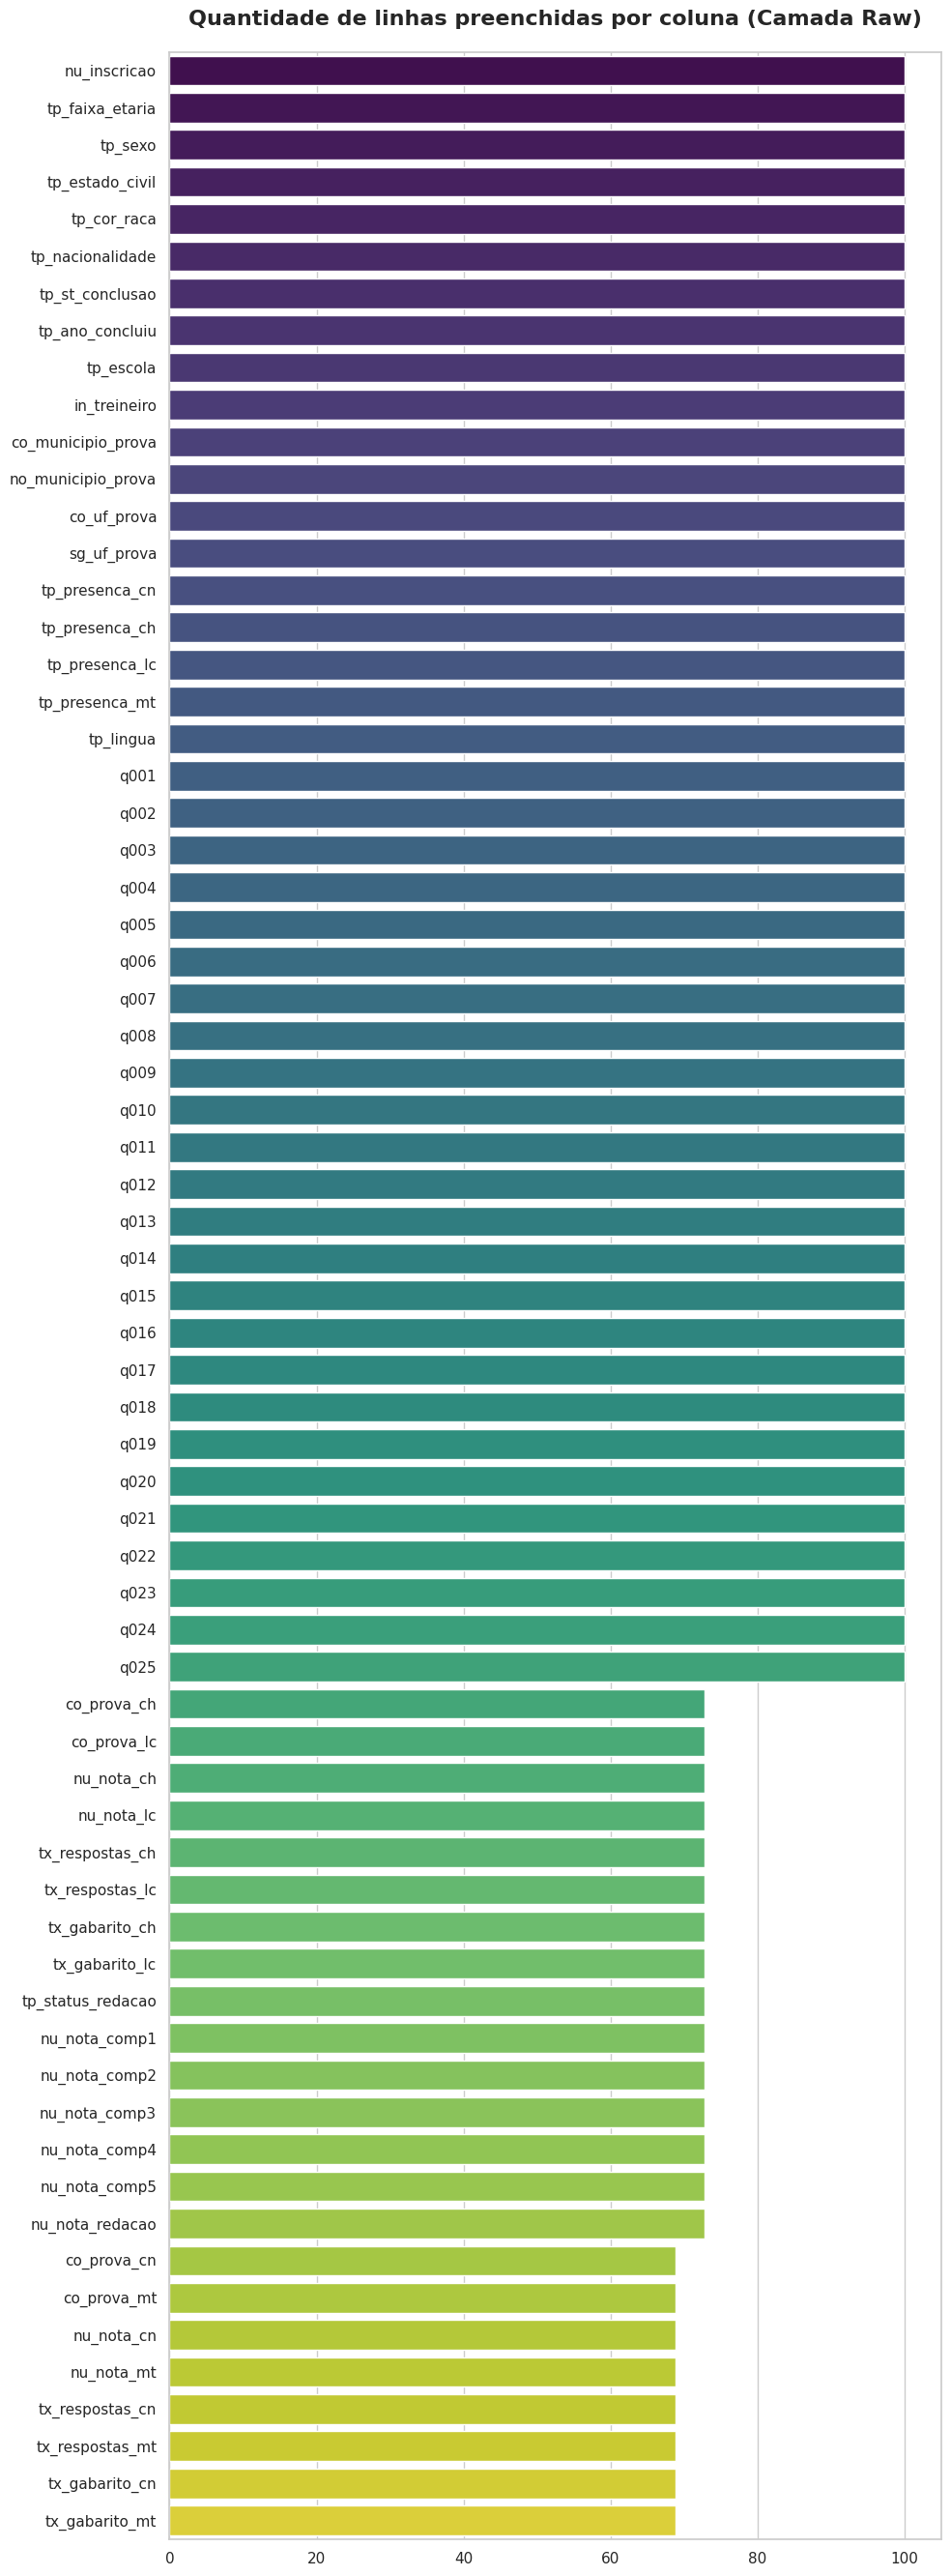

In [3]:
total_sp = df.count()

total_sp_nulos = df.agg(*[F.count(F.col(c)).alias(c) for c in df.columns]).collect()[0].asDict()

coluna_total_nulos = list(total_sp_nulos.keys())
percentual_coluna_nula = [(total_sp_nulos[c]/total_sp) * 100 for c in coluna_total_nulos]

dados_ordenados_completude = sorted(zip(coluna_total_nulos, percentual_coluna_nula), key=lambda x: x[1], reverse=True)

colunas_plot, valores_plot = zip(*dados_ordenados_completude)

plt.figure(figsize=(10, len(colunas_plot) * 0.4))
sns.set_theme(style="whitegrid")

sns.barplot(x=list(valores_plot), y=list(colunas_plot), palette="viridis")

plt.title('Quantidade de linhas preenchidas por coluna (Camada Raw)', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()


#### 2.2 Linhas duplicadas 

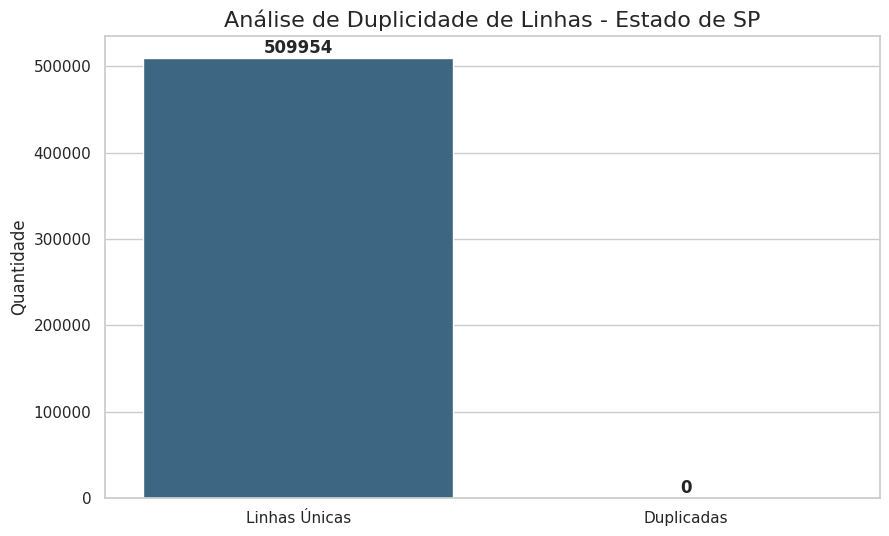

In [4]:
total_linhas = df.count()
total_linhas_unicas = df.distinct().count()
total_duplicados = total_linhas - total_linhas_unicas

categorias = ['Linhas Únicas', 'Duplicadas']
valores = [total_linhas_unicas, total_duplicados]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=categorias, y=valores, hue=categorias, palette='viridis', legend=False)

for i, v in enumerate(valores):
    ax.text(i, v + (max(valores)*0.01), str(v), ha='center', fontweight='bold')

plt.title('Análise de Duplicidade de Linhas - Estado de SP', fontsize=16)
plt.ylabel('Quantidade')
plt.show()

#### 2.3 Análise de Outliers nas notas do ENEM

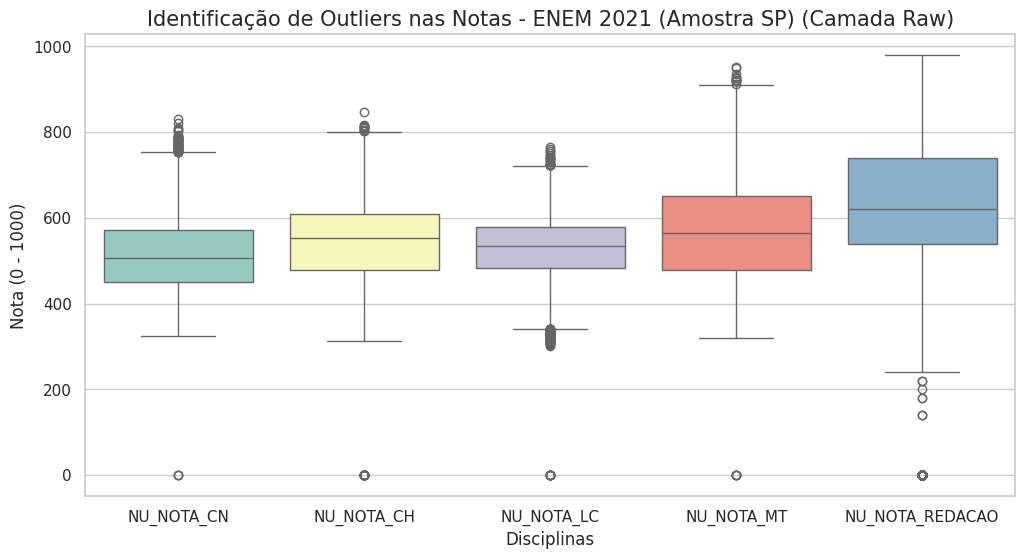

In [5]:
coluna_notas = ["NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_LC", "NU_NOTA_MT", "NU_NOTA_REDACAO"]
resumo_notas = df.select(coluna_notas).describe()

grafico_outlier = df.select(coluna_notas).sample(False, 0.05).toPandas()

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

sns.boxplot(data=grafico_outlier, palette="Set3")

plt.title('Identificação de Outliers nas Notas - ENEM 2021 (Amostra SP) (Camada Raw)', fontsize=15)
plt.ylabel('Nota (0 - 1000)')
plt.xlabel('Disciplinas')
plt.show()

#### 2.4 Rating e dispersão

/tmp/ipykernel_60956/368515953.py:16: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=status_rating, x='RATING', y='count', palette='viridis')
/tmp/ipykernel_60956/368515953.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=status_rating, x='RATING', y='count', palette='viridis')


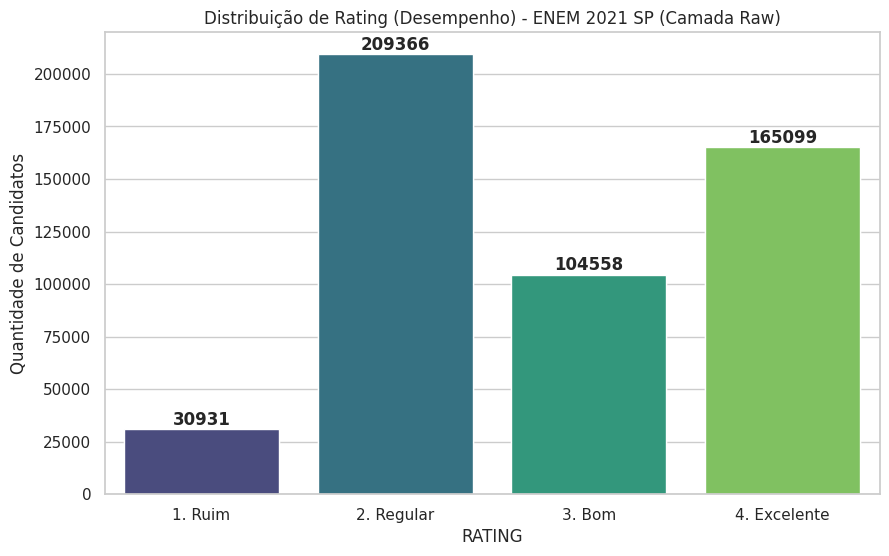

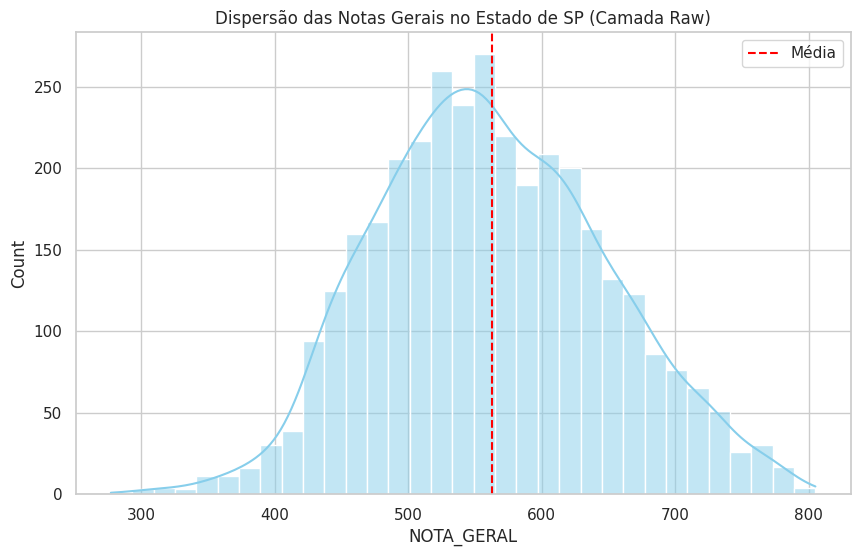

In [6]:
media_SP_notas = df.withColumn("NOTA_GERAL", sum([F.col(c) for c in coluna_notas]) / 5)

media_SP_notas = media_SP_notas.withColumn("RATING",
    F.when(F.col("NOTA_GERAL") < 450, "1. Ruim")
     .when(F.col("NOTA_GERAL") < 600, "2. Regular")
     .when(F.col("NOTA_GERAL") < 750, "3. Bom")
     .otherwise("4. Excelente")
)

status_dispersao = media_SP_notas.select("NOTA_GERAL").summary("mean", "stddev", "min", "25%", "50%", "75%", "max")

status_rating = media_SP_notas.groupBy("RATING").count().orderBy("RATING").toPandas()

plt.figure(figsize=(10, 6))

ax = sns.barplot(data=status_rating, x='RATING', y='count', palette='viridis')

valores = status_rating['count'].values

for i, v in enumerate(valores):
    ax.text(i, v + (max(valores) * 0.01), str(int(v)), ha='center', fontweight='bold')

sns.barplot(data=status_rating, x='RATING', y='count', palette='viridis')
plt.title('Distribuição de Rating (Desempenho) - ENEM 2021 SP (Camada Raw)')
plt.ylabel('Quantidade de Candidatos')
plt.show()

amostra_notas = media_SP_notas.select("NOTA_GERAL").sample(False, 0.01).toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(amostra_notas['NOTA_GERAL'], kde=True, color='skyblue')
plt.axvline(amostra_notas['NOTA_GERAL'].mean(), color='red', linestyle='--', label='Média')
plt.title('Dispersão das Notas Gerais no Estado de SP (Camada Raw)')
plt.legend()
plt.show()

#### 2.5 Outlier da idade dos estudantes do ENEM

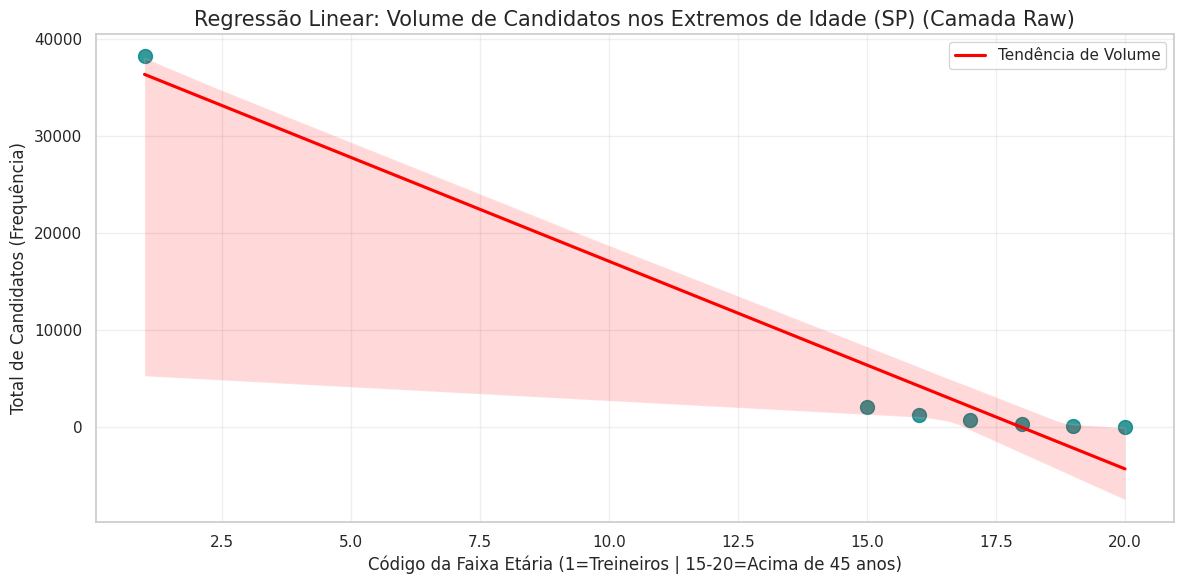

In [7]:
faixa_etaria_estudantes = df.filter(F.col("SG_UF_PROVA") == "SP") \
    .select("TP_FAIXA_ETARIA", "NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_LC", "NU_NOTA_MT", "NU_NOTA_REDACAO") \
    .dropna()

outlier_idade = faixa_etaria_estudantes.filter((F.col("TP_FAIXA_ETARIA") == 1) | (F.col("TP_FAIXA_ETARIA") >= 15))

distribuicao_extremos = outlier_idade.groupBy("TP_FAIXA_ETARIA").count().orderBy("TP_FAIXA_ETARIA").toPandas()

plt.figure(figsize=(12, 6))

sns.regplot(
    data=distribuicao_extremos, 
    x="TP_FAIXA_ETARIA", 
    y="count", 
    color="teal",
    line_kws={"color": "red", "label": "Tendência de Volume"},
    scatter_kws={"s": 100}
)

plt.title('Regressão Linear: Volume de Candidatos nos Extremos de Idade (SP) (Camada Raw)', fontsize=15)
plt.xlabel('Código da Faixa Etária (1=Treineiros | 15-20=Acima de 45 anos)', fontsize=12)
plt.ylabel('Total de Candidatos (Frequência)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()